# MapReduce Algorithm for Image Processing

Author: Shu Liu

Date: 09/05/2024

## Introduction

Inspired by the `MapReduce` algorithm in lsst id_diffim https://github.com/lsst/ip_diffim/blob/main/python/lsst/ip/diffim/imageMapReduce.py , we implement a simple version in this notebook. The `MapReduce` algorithm has three steps. In the first step, an image is cut into $n \times m$ pieces. In the second step, each cutout image is mapped into another image with the same size. In the last step, the mapped cutouts are combined together to have a reconstructed image.

## Crop An Image into $n \times m$ pieces

Method: Let us consider only one dimension of an image. We crop the image into $n$ pieces. For each piece, the image size is $2l + 1$. $l$ is the half size of the cutouts. We also want to remove $w$ piexels from both sizes to avoid edge issue. As a result, the effective size is $2l + 1 - 2w$. In the effective region, we allow two neighboring cutouts to have $o$ pixels overlap. We summarize these quantities below

- $l$: (half_size) half size of the cutout image, cutout image has $2l +1$ pixels in each dimension
- $w$: (edge_size) width of edge pixels which are unused, effective area of an image is $2l + 1 - 2w$
- $o$: (effective_overlap) overlapping size between effective pixels 

If an image of size $s$ is cropped into $n$ pieces, we have

$s = n(2l + 1) - (n-1)2w - (n-1)o$

We can solve $l$ as

$l = \frac{S + (n-1)(2w + o)}{2n} - \frac{1}{2} \le \mathrm{ROUND}(\frac{S + (n-1)(2w + o)}{2n})$

We use $\mathrm{ROUND}(\frac{S + (n-1)(2w + o)}{2n})$ as the half size of the cutout image.

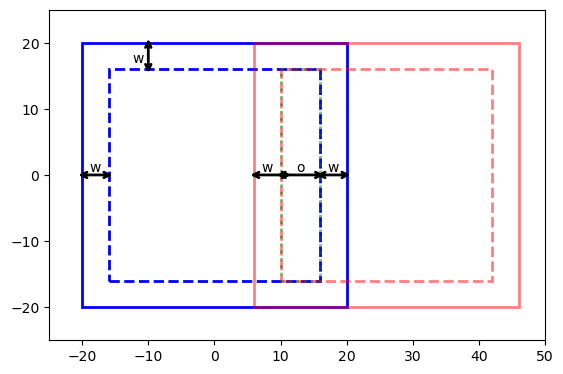

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches


fig, ax = plt.subplots()
outer_box = patches.Rectangle((-20, -20), 40, 40, edgecolor='blue', facecolor='none', lw=2)
ax.add_patch(outer_box)

effective_box =  patches.Rectangle((-16, -16), 32, 32, edgecolor='blue', facecolor='none', lw=2, linestyle='dashed')
ax.add_patch(effective_box)

outer_box_2 = patches.Rectangle((6, -20), 40, 40, edgecolor='red', facecolor='none', lw=2, alpha=0.5)
ax.add_patch(outer_box_2)

effective_box_2 =  patches.Rectangle((10, -16), 32, 32, edgecolor='red', facecolor='none', lw=2, linestyle='dashed', alpha=0.5)
ax.add_patch(effective_box_2)

inner_box = patches.Rectangle((10, -16), 6, 32, edgecolor='green', facecolor='none', lw=2, linestyle='dotted', alpha=0.5)
ax.add_patch(inner_box)

ax.annotate('', xy=(21, 0), xytext=(15, 0), arrowprops=dict(arrowstyle='<->', lw=2))
ax.text(18, 0.5, 'w', ha='center')

ax.annotate('', xy=(12, 0), xytext=(5, 0), arrowprops=dict(arrowstyle='<->', lw=2))
ax.text(8, 0.5, 'w', ha='center')

ax.annotate('', xy=(17, 0), xytext=(9, 0), arrowprops=dict(arrowstyle='<->', lw=2))
ax.text(13, 0.5, 'o', ha='center')

ax.annotate('', xy=(-10, 15), xytext=(-10, 21), arrowprops=dict(arrowstyle='<->', lw=2))
ax.text(-11.5, 17, 'w', ha='center')


ax.annotate('', xy=(-15, 0), xytext=(-21, 0), arrowprops=dict(arrowstyle='<->', lw=2))
ax.text(-18, 0.5, 'w', ha='center')


ax.set_xlim(-25, 50)
ax.set_ylim(-25, 25)
ax.set_aspect('equal')

To demonstrate this method, we create a test image with Gaussian stars and crop it into $4 \times 3$ pieces.

In [2]:
import numpy as np
from scipy.stats import multivariate_normal

def compute_xy_grids(x_len, y_len):
    x = np.arange(- x_len // 2 + 1, x_len // 2 + 1, 1)
    y = np.arange(- y_len // 2 + 1, y_len // 2 + 1, 1)
    xx, yy = np.meshgrid(x, y)
    return xx, yy

def Gaussian2d(xx, yy, m=[0., 0.], cov=[[1, 0], [0, 1]]):
    grid = np.dstack((xx, yy))
    var = multivariate_normal(mean=m, cov=cov)
    return var.pdf(grid)

def sim_spatially_varying_sigma(x, y, sigma, T=20, alpha=0.):
    sigma_x = sigma + alpha * np.sin(2 * np.pi / T * x) * sigma
    sigma_y = sigma + alpha * np.sin(2 * np.pi / T * y) * sigma
    return sigma_x, sigma_y

def sim_source_catalog(n_sources, x_lim, y_lim, min_flux, max_flux, random_seed=None):
    if random_seed is not None:
        np.random.seed(random_seed)
    x_pos = np.random.uniform(x_lim[0], x_lim[1], n_sources)
    y_pos = np.random.uniform(y_lim[0], y_lim[1], n_sources)  
    fluxes = np.random.uniform(min_flux, max_flux, n_sources)
    source_catalog = {'x_pos': x_pos, 'y_pos': y_pos, 'fluxes': fluxes}
    return source_catalog

def sim_star(x_size, y_size, x, y, flux, psf_sig):
    image_xx, image_yy = compute_xy_grids(x_size, y_size)
    star_im = flux * Gaussian2d(
            image_xx, image_yy, m=[x, y], cov=[[psf_sig, 0], [0, psf_sig]]
        )
    return star_im

def sim_image(image_size, sky_sig, psf_sig, source_catalog, T=20, alpha=0.1):
    image_xx, image_yy = compute_xy_grids(image_size, image_size)
    image_grid = np.dstack((image_xx, image_yy))
    image =  np.random.normal(scale=sky_sig, size=(image_size, image_size))
    # add background sources
    fluxes = source_catalog['fluxes']
    x_pos, y_pos = source_catalog['x_pos'], source_catalog['y_pos']

    for i in range(len(fluxes)):
        x, y = x_pos[i], y_pos[i]
        sigma_x, sigma_y = sim_spatially_varying_sigma(x, y, psf_sig, T=T, alpha=alpha)
        image += fluxes[i] * Gaussian2d(
            image_xx, image_yy, m=[x, y], cov=[[sigma_x, 0], [0, sigma_y]]
        )
    return image

In [3]:
np.random.seed(0)
source_catalog = sim_source_catalog(n_sources=500, x_lim=(-250, 250), y_lim=(-250, 250),
                                    min_flux=50, max_flux=150, random_seed=None)
image = sim_image(500, 1, 3, source_catalog, T=20, alpha=0.1)

Text(0.5, 1.0, 'test image')

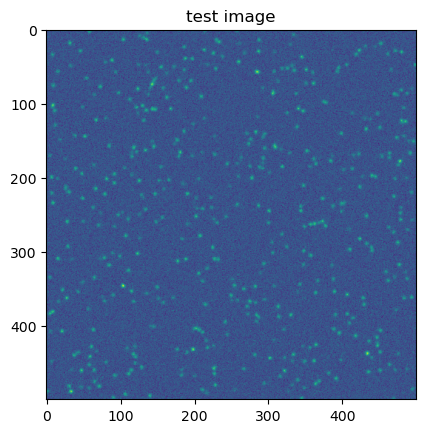

In [4]:
plt.imshow(image)
plt.title('test image')

In [5]:
def cal_half_size(num_pieces, image_size, edge_size, effective_overlap):
    return int(
        np.round(
            ( image_size + ( num_pieces - 1 ) * (2 * edge_size + effective_overlap) ) / ( 2 * num_pieces)
        )
    )

def cal_cutout_centers(num_pieces_x, num_pieces_y, half_size_x, half_size_y, edge_size_x, edge_size_y, effective_overlap_x, effective_overlap_y):
    cutout_centers = {}
    xc, yc = 0, 0
    for nx in range(0, num_pieces_x):
        xc = half_size_x + nx * ( 2 * half_size_x - 2 * edge_size_x - effective_overlap_x + 1 )

        for ny in range(0, num_pieces_y):
            yc = half_size_y + ny * ( 2 * half_size_y - 2 * edge_size_y - effective_overlap_y + 1 )
            cutout_centers[f'{nx}{ny}'] = (xc, yc)
    return cutout_centers

def make_cutouts(data, cutout_centers, num_pieces_x, num_pieces_y, half_size_x, half_size_y):

    all_cutouts = {}

    for nx in range(0, num_pieces_x):
        for ny in range(0, num_pieces_y):
            xc, yc = cutout_centers[f'{nx}{ny}']
            x_min = max(0, xc - half_size_x)
            x_max = min(data.shape[1] - 1, xc + half_size_x)

            y_min = max(0, yc - half_size_y)
            y_max = min(data.shape[0] - 1, yc + half_size_y)

            cutout = data[y_min: y_max + 1, x_min: x_max + 1]
            all_cutouts[f'{nx}{ny}'] = cutout
    return all_cutouts

In [6]:
num_pieces_x, num_pieces_y = 4, 3
edge_size_x, edge_size_y = 40, 50
effective_overlap_x, effective_overlap_y = 20, 30

image_size_x, image_size_y = image.shape[1], image.shape[0]
half_size_x = cal_half_size(num_pieces_x, image_size_x, edge_size_x, effective_overlap_x)
half_size_y = cal_half_size(num_pieces_y, image_size_y, edge_size_y, effective_overlap_y)

cutout_centers = cal_cutout_centers(num_pieces_x, num_pieces_y, half_size_x, half_size_y, 
                                    edge_size_x, edge_size_y, effective_overlap_x, effective_overlap_y)

cutouts = make_cutouts(image, cutout_centers, num_pieces_x, num_pieces_y,
                       half_size_x, half_size_y)
        

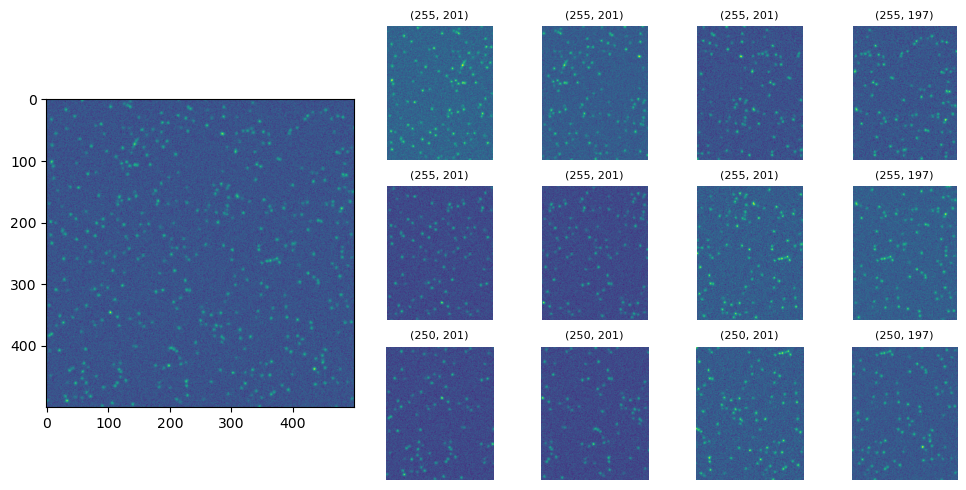

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(10, 5))

gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2])

ax1 = plt.subplot(gs[0])
ax1.imshow(image)


gs_right = gridspec.GridSpecFromSubplotSpec(3, 4, subplot_spec=gs[1])

for i in range(12):
    ax = plt.subplot(gs_right[i])
    cutout = cutouts[f'{i%4}{i//4}']
    ax.imshow(cutout)
    ax.axis('off')
    ax.set_title(f'{cutout.shape}', fontsize=8)

plt.tight_layout()
plt.show()


## Map Each Cutout onto Another Image with the Same Shape

After cropping the image into cutouts, we apply operations such as convolution and multiplication to each cutout. This step can be executed using multithreading or parallel processing as long as the operation on each cutout is independent. Here we apply an identical map using multithreading.

In [8]:
from concurrent.futures import ThreadPoolExecutor

def mapper(cutouts, num_pieces_x, num_pieces_y):
    with ThreadPoolExecutor() as executor:
        futures = {}
        for nx in range(num_pieces_x):
            for ny in range(num_pieces_y):
                cutout = cutouts[f'{nx}{ny}']
                futures[f'{nx}{ny}'] = executor.submit(lambda x: x, cutout)
    map_results = {}
    for nx in range(num_pieces_x):
            for ny in range(num_pieces_y):
                future = futures[f'{nx}{ny}']
                map_results[f'{nx}{ny}'] = future.result()
    return map_results

In [9]:
mapped_cutouts = mapper(cutouts, num_pieces_x, num_pieces_y)

In [10]:
residual = []
for nx in range(num_pieces_x):
    for ny in range(num_pieces_y):
        cutout = cutouts[f'{nx}{ny}']
        mapped_cutout = mapped_cutouts[f'{nx}{ny}']
        residual.extend((cutout - mapped_cutout).flatten())
        

In [11]:
np.unique(residual)

array([0.])

## Reduce Mapped Cutouts into An Reconstructed Image

We reconstruct an image by combining mapped cutouts with weights on the overlapping region. We first combine cutouts along the vertical direction. Since each vertically reconstructed stamp is independent to the other, multithreading or parallel processing can be applied. After gettinng all vertically reconstructed stamps, we combine them along the horizontal direction to get the reconstructed image. 

To combine two neighbour cutouts, we need to remove the pixels from the edge. Then we apply weights on the effective overlapping region to linearly combine them together. All the weights at each pixel should sum to one. We use Gaussian weights in this notebook.

In [21]:
from concurrent.futures import ThreadPoolExecutor

def compute_gaussian_weights(position, sigma, n_repeats):
    gaussian_values = np.exp(-0.5 * (position / sigma) ** 2)
    return np.tile(gaussian_values[:, np.newaxis], n_repeats)

def stack_cutouts_vertiaclly(nx, cutouts, num_pieces_y, edge_size_y, effective_overlap_y):
    for ny in range(num_pieces_y):
        if ny == 0:
            vertical_stack = cutouts[f'{nx}{ny}']
            vertical_weights = compute_gaussian_weights(
                position=np.arange(0, effective_overlap_y),
                sigma=effective_overlap_y//3,
                n_repeats=vertical_stack.shape[1])
        else:
            vertical_stack = vertical_stack[0: -edge_size_y, :]
            cutout = cutouts[f'{nx}{ny}']
            cutout = cutout[edge_size_y:, :]
            vertical_stack[-effective_overlap_y:,:] = vertical_stack[-effective_overlap_y:,:] * vertical_weights \
                                                    + cutout[0: effective_overlap_y, :] * (1 - vertical_weights)
            vertical_stack = np.vstack( (vertical_stack, cutout[effective_overlap_y:, :]) )
    return vertical_stack

def reconstruct_image_using_vertical_stack(reconstructed_image, horizontal_weights, vertical_stack, edge_size_x, effective_overlap_x):
    reconstructed_image = reconstructed_image[:, 0: -edge_size_x]
    vertical_stack = vertical_stack[:, edge_size_x:]
    reconstructed_image[:, -effective_overlap_x:] = reconstructed_image[:, -effective_overlap_x:] * horizontal_weights \
                                                  + vertical_stack[:, 0: effective_overlap_x] * (1 - horizontal_weights)
    reconstructed_image = np.hstack( (reconstructed_image, vertical_stack[:, effective_overlap_x:]) )
    return reconstructed_image

with ThreadPoolExecutor() as executor:
    futures = []
    for nx in range(num_pieces_x):
        futures.append(executor.submit(stack_cutouts_vertiaclly, nx, cutouts, num_pieces_y, edge_size_y, effective_overlap_y))

reconstructed_image = futures[0].result()
horizontal_weights = compute_gaussian_weights(position=np.arange(0, effective_overlap_x),
                                                       sigma=effective_overlap_x//3,
                                                       n_repeats=reconstructed_image.shape[0])
horizontal_weights = horizontal_weights.T
for nx in range(1, num_pieces_x):
    vertical_stack = futures[nx].result()
    reconstructed_image = reconstruct_image_using_vertical_stack(reconstructed_image, horizontal_weights, vertical_stack, edge_size_x, effective_overlap_x)

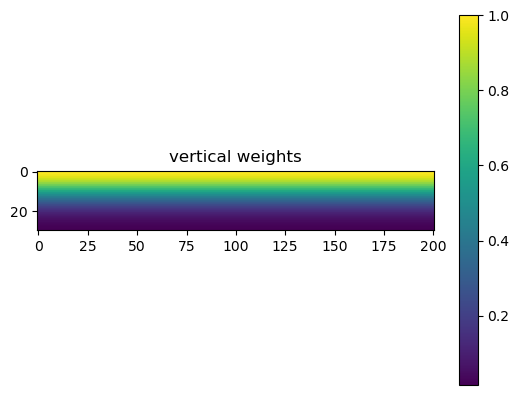

In [22]:
vertical_weights = compute_gaussian_weights(
    position=np.arange(0, effective_overlap_y),
    sigma=effective_overlap_y//3,
    n_repeats=cutouts['00'].shape[1])

plt.imshow(vertical_weights)
plt.title("vertical weights")
plt.colorbar()

Text(0.5, 1.0, 'vertical weights')

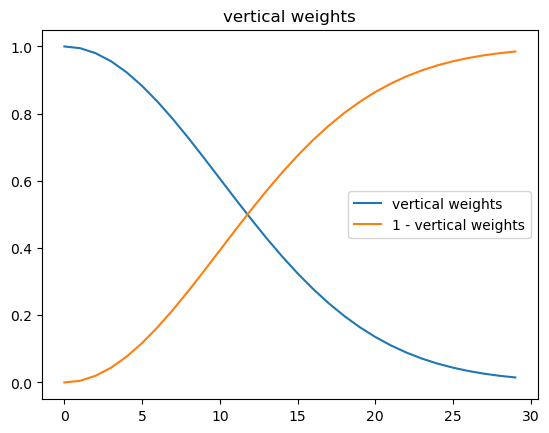

In [24]:
plt.plot(vertical_weights[:,0], label='vertical weights')
plt.plot(1-vertical_weights[:,0], label='1 - vertical weights')
plt.legend()
plt.title("vertical weights")

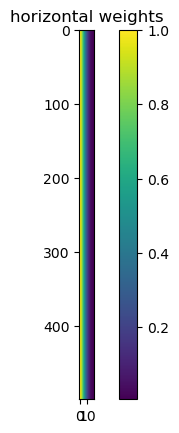

In [25]:
plt.imshow(horizontal_weights)
plt.title("horizontal weights")
plt.colorbar()

Text(0.5, 1.0, 'horizontal weights')

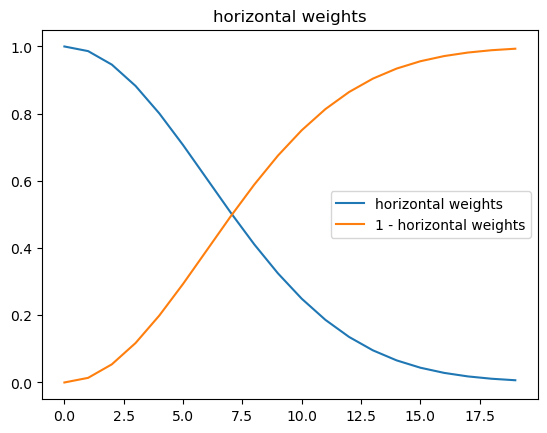

In [26]:
plt.plot(horizontal_weights[0, :], label='horizontal weights')
plt.plot(1-horizontal_weights[0, :], label='1 - horizontal weights')
plt.legend()
plt.title("horizontal weights")

Text(0.5, 1.0, 'reconstructed image')

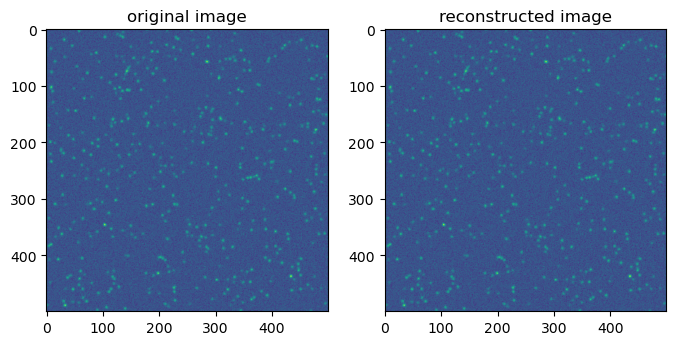

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(image)
ax[0].set_title('original image')
ax[1].imshow(reconstructed_image)
ax[1].set_title('reconstructed image')

In [34]:
image.shape, reconstructed_image.shape

((500, 500), (500, 500))

(array([1.00000e+00, 0.00000e+00, 0.00000e+00, 2.40000e+01, 0.00000e+00,
        6.80000e+02, 2.47767e+05, 1.37100e+03, 1.33000e+02, 2.40000e+01]),
 array([-1.77635684e-15, -1.50990331e-15, -1.24344979e-15, -9.76996262e-16,
        -7.10542736e-16, -4.44089210e-16, -1.77635684e-16,  8.88178420e-17,
         3.55271368e-16,  6.21724894e-16,  8.88178420e-16]),
 <BarContainer object of 10 artists>)

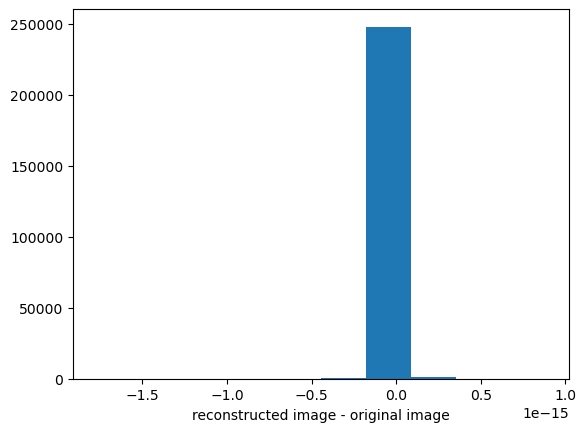

In [33]:
plt.xlabel("reconstructed image - original image")
plt.hist((reconstructed_image - image).ravel())

## Wrap Up in a Class

In [37]:
import numpy as np
from concurrent.futures import ThreadPoolExecutor



class DIAMapReduce:
    def __init__(self,
                 num_pieces_x: int=3, num_pieces_y: int=3,
                 edge_size_x: int=50, edge_size_y: int=50,
                 effective_overlap_x: int=30, effective_overlap_y: int=30):

        self.num_pieces_x = num_pieces_x
        self.num_pieces_y = num_pieces_y
        self.edge_size_x = edge_size_x
        self.edge_size_y = edge_size_y
        self.effective_overlap_x = effective_overlap_x
        self.effective_overlap_y = effective_overlap_y
        
    def mapper(self, cutouts):
        with ThreadPoolExecutor() as executor:
            futures = {}
            for nx in range(self.num_pieces_x):
                for ny in range(self.num_pieces_y):
                    cutout = cutouts[f'{nx}{ny}']
                    futures[f'{nx}{ny}'] = executor.submit(lambda x: x, cutout)
        map_results = {}
        for nx in range(self.num_pieces_x):
                for ny in range(self.num_pieces_y):
                    future = futures[f'{nx}{ny}']
                    map_results[f'{nx}{ny}'] = future.result()
        return map_results
    
    def reducer(self, cutouts):
        def _compute_gaussian_weights(position, sigma, n_repeats):
            gaussian_values = np.exp(-0.5 * (position / sigma) ** 2)
            return np.tile(gaussian_values[:, np.newaxis], n_repeats)

        def _stack_cutouts_vertiaclly(nx, cutouts, num_pieces_y, edge_size_y, effective_overlap_y):
            for ny in range(num_pieces_y):
                if ny == 0:
                    vertical_stack = cutouts[f'{nx}{ny}']
                    vertical_weights = _compute_gaussian_weights(
                        position=np.arange(0, effective_overlap_y),
                        sigma=effective_overlap_y//3,
                        n_repeats=vertical_stack.shape[1])
                else:
                    vertical_stack = vertical_stack[0: -edge_size_y, :]
                    cutout = cutouts[f'{nx}{ny}']
                    cutout = cutout[edge_size_y:, :]
                    vertical_stack[-effective_overlap_y:,:] = vertical_stack[-effective_overlap_y:,:] * vertical_weights \
                                                            + cutout[0: effective_overlap_y, :] * (1 - vertical_weights)
                    vertical_stack = np.vstack( (vertical_stack, cutout[effective_overlap_y:, :]) )
            return vertical_stack

        def _reconstruct_image_using_vertical_stack(reconstructed_image, horizontal_weights, vertical_stack, edge_size_x, effective_overlap_x):
            reconstructed_image = reconstructed_image[:, 0: -edge_size_x]
            vertical_stack = vertical_stack[:, edge_size_x:]
            reconstructed_image[:, -effective_overlap_x:] = reconstructed_image[:, -effective_overlap_x:] * horizontal_weights \
                                                          + vertical_stack[:, 0: effective_overlap_x] * (1 - horizontal_weights)
            reconstructed_image = np.hstack( (reconstructed_image, vertical_stack[:, effective_overlap_x:]) )
            return reconstructed_image

        # reconstruct vertically
        with ThreadPoolExecutor() as executor:
            futures = []
            for nx in range(self.num_pieces_x):
                futures.append(executor.submit(stack_cutouts_vertiaclly, nx, cutouts, self.num_pieces_y, self.edge_size_y, self.effective_overlap_y))

        reconstructed_image = futures[0].result()

        # reconstruct horizontally
        horizontal_weights = _compute_gaussian_weights(position=np.arange(0, self.effective_overlap_x),
                                                               sigma=self.effective_overlap_x//3,
                                                               n_repeats=reconstructed_image.shape[0])
        horizontal_weights = horizontal_weights.T

        for nx in range(1, self.num_pieces_x):
            vertical_stack = futures[nx].result()
            reconstructed_image = reconstruct_image_using_vertical_stack(reconstructed_image, horizontal_weights, vertical_stack, self.edge_size_x, self.effective_overlap_x)
        return reconstructed_image

    def run(self, data):
        image_size_x, image_size_y = data.shape[1], data.shape[0]
        half_size_x = DIAMapReduce._cal_half_size(self.num_pieces_x, image_size_x, self.edge_size_x, self.effective_overlap_x)
        half_size_y = DIAMapReduce._cal_half_size(self.num_pieces_y, image_size_y, self.edge_size_y, self.effective_overlap_y)
        
        cutout_centers = self._cal_cutout_centers(half_size_x, half_size_y)
        
        cutouts = self._make_cutouts(data, cutout_centers, half_size_x, half_size_y)
        
        cutouts_mapped = self.mapper(cutouts)
        reconstructed_image = self.reducer(cutouts_mapped)
        
        return reconstructed_image
        
    @staticmethod
    def _cal_half_size(num_pieces, length, edge_size, effective_overlap):
        return int(
            np.round(
                ( length + ( num_pieces - 1 ) * (2 * edge_size + effective_overlap) ) / ( 2 * num_pieces)
            )
        )
    
    def _cal_cutout_centers(self, half_size_x, half_size_y):
        cutout_centers = {}
        xc, yc = 0, 0
        for nx in range(0, self.num_pieces_x):
            xc = half_size_x + nx * ( 2 * half_size_x - 2 * self.edge_size_x - self.effective_overlap_x + 1 )
            
            for ny in range(0, self.num_pieces_y):
                yc = half_size_y + ny * ( 2 * half_size_y - 2 * self.edge_size_y - self.effective_overlap_y + 1 )
                cutout_centers[f'{nx}{ny}'] = (xc, yc)
        return cutout_centers
    
    def _make_cutouts(self, data, cutout_centers, half_size_x, half_size_y):
        
        all_cutouts = {}
        
        for nx in range(0, self.num_pieces_x):
            for ny in range(0, self.num_pieces_y):
                xc, yc = cutout_centers[f'{nx}{ny}']
                x_min = max(0, xc - half_size_x)
                x_max = min(data.shape[1] - 1, xc + half_size_x)
                
                y_min = max(0, yc - half_size_y)
                y_max = min(data.shape[0] - 1, yc + half_size_y)
                
                cutout = data[y_min: y_max + 1, x_min: x_max + 1]
                all_cutouts[f'{nx}{ny}'] = cutout
        return all_cutouts

In [38]:
num_pieces_x, num_pieces_y = 4, 3
edge_size_x, edge_size_y = 40, 50
effective_overlap_x, effective_overlap_y = 20, 30
mapreduce = DIAMapReduce(num_pieces_x, num_pieces_y, edge_size_x, edge_size_y, effective_overlap_x, effective_overlap_y)

In [39]:
reconstructed_image = mapreduce.run(image)

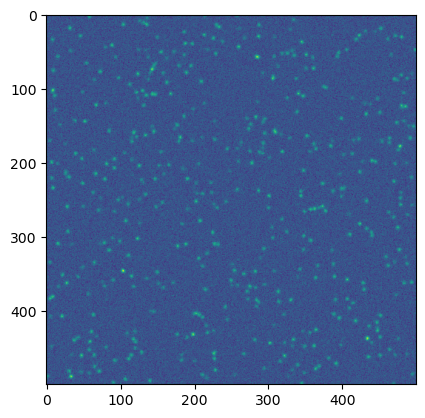

In [41]:
plt.imshow(reconstructed_image)